In [1]:
! open -a Docker

Using Jane Ho's repo as reference: https://github.com/janehojy/vault-demo-kmse/blob/main/vault-demo-key-management-kms.ipynb

In [2]:
%env VAULT_ADDR=http://127.0.0.1:8200
%env VAULT_TOKEN=root
%env VAULT_KMIP_PORT=5696
%env VAULT_PORT=8200

env: VAULT_ADDR=http://127.0.0.1:8200
env: VAULT_TOKEN=root
env: VAULT_KMIP_PORT=5696
env: VAULT_PORT=8200


# [AWS KMS](https://developer.hashicorp.com/vault/docs/secrets/key-management/awskms)

### Create a Vault Server in Docker

In [3]:
%%bash

# For this demo, we will be passing our doormat credentials as environment variables.
# For non-doormat scenarios, use your configured IAM programmatic credentials in the secret sync configuration later on.
# Change the path to your license file
# KMIP enabled for second test
export VAULT_LICENSE=$(cat license.hclic)

# Refresh Vault docker image with latest version
docker pull hashicorp/vault-enterprise

docker run -d --rm --name vault-enterprise --cap-add=IPC_LOCK \
-e "VAULT_DEV_ROOT_TOKEN_ID=${VAULT_TOKEN}" \
-e "VAULT_DEV_LISTEN_ADDRESS=:${VAULT_PORT}" \
-e "VAULT_LICENSE=${VAULT_LICENSE}" \
-p ${VAULT_KMIP_PORT}:${VAULT_KMIP_PORT} \
-p ${VAULT_PORT}:${VAULT_PORT} hashicorp/vault-enterprise:latest

Using default tag: latest
latest: Pulling from hashicorp/vault-enterprise
Digest: sha256:89e46917844168dec229d7f0aa2d4703fa3335e23c7b62f16adac8ac63da83ca
Status: Image is up to date for hashicorp/vault-enterprise:latest
docker.io/hashicorp/vault-enterprise:latest
9b455d39abd521471c20face6eda36bd662bdc7af9922fa3ec5f912abd5186f3


### Check if Vault is running

In [4]:
! docker ps

CONTAINER ID   IMAGE                               COMMAND                  CREATED         STATUS         PORTS                                            NAMES
9b455d39abd5   hashicorp/vault-enterprise:latest   "docker-entrypoint.s…"   4 seconds ago   Up 3 seconds   0.0.0.0:5696->5696/tcp, 0.0.0.0:8200->8200/tcp   vault-enterprise


### Enable the Key Management secrets engine

In [ ]:
! vault secrets enable -path=kms-aws keymgmt

Success! Enabled the keymgmt secrets engine at: kms-aws/


### Configure the KMSE Engine with `awskms` provider

In [6]:
%%bash
# For HashiCorp staff only.  Log in via doormat and populate your AWS credentials into your environment variables.

doormat login -f
eval $(doormat aws -a aws_jose.merchan_test export)

export AWS_REGION=eu-west-1

vault write kms-aws/kms/demo-aws \
    provider="awskms" \
    key_collection="${AWS_REGION}" \
    credentials=access_key="${AWS_ACCESS_KEY_ID}" \
    credentials=secret_key="${AWS_SECRET_ACCESS_KEY}" \
    credentials=session_token="${AWS_SESSION_TOKEN}"

time="2024-11-20T14:50:30+01:00" level=warning msg="new doormat cli recommended: v4.4.0 run `doormat update` to update!"
time="2024-11-20T14:50:30+01:00" level=info msg="logging into doormat..."
time="2024-11-20T14:50:34+01:00" level=info msg="successfully logged into doormat!"


Success! Data written to: kms-aws/kms/demo-aws


### Create keys on KMSE Engine

In [7]:
%%bash
vault write kms-aws/key/aes256-gcm96-1 type="aes256-gcm96"
vault write kms-aws/key/aes256-gcm96-2 type="aes256-gcm96"

Success! Data written to: kms-aws/key/aes256-gcm96-1
Success! Data written to: kms-aws/key/aes256-gcm96-2


### Read keys

In [8]:
%%bash
vault read -format=json kms-aws/key/aes256-gcm96-1 | jq
vault read -format=json kms-aws/key/aes256-gcm96-2 | jq

{
  "request_id": "9a8f84de-feff-6eaa-0928-425007acb3bd",
  "lease_id": "",
  "lease_duration": 0,
  "renewable": false,
  "data": {
    "deletion_allowed": false,
    "latest_version": 1,
    "min_enabled_version": 1,
    "name": "aes256-gcm96-1",
    "type": "aes256-gcm96",
    "versions": {
      "1": {
        "creation_time": "2024-11-20T13:53:21.807827384Z"
      }
    }
  },
  "warnings": null
}
{
  "request_id": "ef5aa588-cff1-0f72-ee4e-a99a5c958a82",
  "lease_id": "",
  "lease_duration": 0,
  "renewable": false,
  "data": {
    "deletion_allowed": false,
    "latest_version": 1,
    "min_enabled_version": 1,
    "name": "aes256-gcm96-2",
    "type": "aes256-gcm96",
    "versions": {
      "1": {
        "creation_time": "2024-11-20T13:53:21.875434884Z"
      }
    }
  },
  "warnings": null
}


### Distribute keys to AWS KMS

In [9]:
%%bash

vault write kms-aws/kms/demo-aws/key/aes256-gcm96-1 \
    purpose="encrypt,decrypt" \
    protection="hsm"

vault write kms-aws/kms/demo-aws/key/aes256-gcm96-2 \
    purpose="encrypt,decrypt" \
    protection="hsm"

Success! Data written to: kms-aws/kms/demo-aws/key/aes256-gcm96-1
Success! Data written to: kms-aws/kms/demo-aws/key/aes256-gcm96-2


Visit https://doormat.hashicorp.services/ and open console

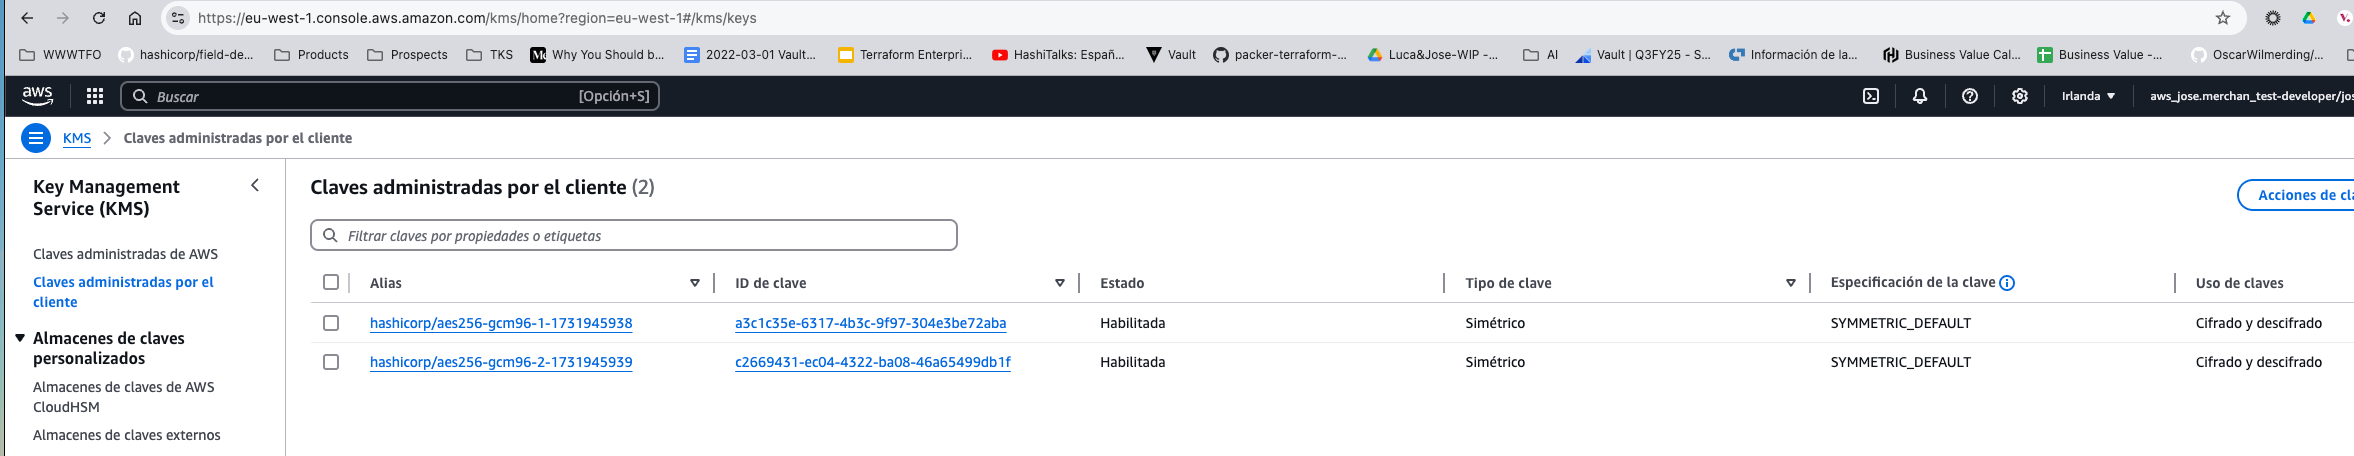

# Clean UP

### Remove keys

In [ ]:
%%bash
vault delete kms-aws/kms/demo-aws/key/aes256-gcm96-1
vault delete kms-aws/kms/demo-aws/key/aes256-gcm96-2

### Disable Secret Engine

In [ ]:
! vault secrets disable kms-aws

### Remove Vault container

In [12]:
! docker stop vault-enterprise

vault-enterprise
